##  A/B–тестирование результатов эксперимента по введению новой механики оплаты на сайте

 В ходе тестирования гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Нам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
!pip install statsmodels
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
groups     = pd.read_csv("2_groups.csv", sep=";")
groups_add = pd.read_csv( "group_add.csv")
checks     = pd.read_csv( "2_checks.csv", sep=";")
active     = pd.read_csv("active_studs.csv", sep=";")

In [3]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [4]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [5]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [6]:
active

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [7]:
# Объединение groups_add с основным groups
groups_full = pd.concat([groups, groups_add], ignore_index=True)


In [8]:
groups_full

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [9]:
checks = checks.rename(columns={"student_id": "student_id", "rev": "revenue"})
groups_full = groups_full.rename(columns={"id": "student_id", "grp": "group"})

In [10]:
checks

,student_id,revenue
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [11]:
groups_full

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [12]:
# Убираем дубли(если будут)
groups_full = groups_full.drop_duplicates(subset="student_id")

In [13]:
groups_full

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [14]:
# оставим только активных, у которых известна группа
participants = active.merge(groups_full, on="student_id", how="inner")

In [15]:
participants

,student_id,group
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [16]:
# объединим с оплатами
checks_part = checks.merge(participants, on="student_id", how="inner")

In [17]:
checks_part

,student_id,revenue,group
0,1627,990.0000,A
1,100300,990.0000,B
2,108270,290.0000,B
3,264473,1900.0001,B
4,274352,690.0000,B
...,...,...,...
387,5645737,1900.0000,B
388,5651566,1900.0000,B
389,5662322,1900.0000,B
390,5681918,1900.0000,B


In [18]:
# Сумма на пользователя
user_rev = checks_part.groupby(["student_id", "group"], as_index=False)["revenue"].sum()
user_rev["payer"] = user_rev["revenue"] > 0


# Полная таблица активных (включая тех, кто не платил)
users_full = participants.merge(user_rev, on=["student_id","group"], how="left")
users_full["revenue"] = users_full["revenue"].fillna(0.0)
users_full["payer"] = users_full["payer"].fillna(False)

In [19]:
user_rev

,student_id,group,revenue,payer
0,1627,A,990.0000,True
1,100300,B,990.0000,True
2,108270,B,290.0000,True
3,264473,B,1900.0001,True
4,274352,B,690.0000,True
...,...,...,...,...
387,5645737,B,1900.0000,True
388,5651566,B,1900.0000,True
389,5662322,B,1900.0000,True
390,5681918,B,1900.0000,True


In [20]:
users_full

,student_id,group,revenue,payer
0,581585,A,0.0,False
1,5723133,A,0.0,False
2,3276743,B,0.0,False
3,4238589,A,0.0,False
4,4475369,B,0.0,False
...,...,...,...,...
8336,1794344,B,0.0,False
8337,296883,B,0.0,False
8338,3598448,B,0.0,False
8339,3610547,B,290.0,True


In [21]:
# Найдем отдельно студентов, которые оплатили, но не были активными.В дальнейшем анализе они не будут участвовать, 
# мы их отфильтровываем на этапе предобработки данных (сначала взяли только активных, а потом объединили с оплатами)

# студенты, которые оплатили
paid_students = set(checks['student_id'].unique())

# студенты, которые были активны
active_students = set(active['student_id'].unique())

# те, кто оплатил, но не был активен
paid_not_active = paid_students - active_students

print("Количество студентов, оплативших, но не активных:", len(paid_not_active))

Количество студентов, оплативших, но не активных: 149


### Выбор метрик
Предполагаем, что целью тестируемой гипотезы по введению новой механики оплаты на сайте - увеличение количества оплат. У нас нет всех данных, но скорее всего команда предположила что старая схема не так удобна, возможно есть трудности у пользователя из-за которых не совершается так много покупок. Исходя из той информации, которая у нас есть , мы можем выбрпать следующие метрики :

- конверсия в платящего клиента  
- средний доход на одного платящего клиента (ARPPU)
- ARPU (средний доход на пользователя)



In [22]:
# метрики
summary = users_full.groupby("group").agg(users=("student_id", "nunique"),payers=("payer", "sum"),\
                                          total_revenue=("revenue", "sum"),)
summary["conversion"] = summary["payers"] / summary["users"]
summary["arpu"] = summary["total_revenue"] / summary["users"]
summary["arppu"] = summary["total_revenue"] / summary["payers"].replace({0: np.nan})


In [23]:
summary

,users,payers,total_revenue,conversion,arpu,arppu
group,,,,,,
A,1538,78,72820.0000,0.050715,47.347204,933.589744
B,6803,314,394974.0035,0.046156,58.058798,1257.878992


#### Проанализируем и проверим все метрики. Пусть у нас будут такие гипотезы для каждой:

conversion  

- Конверсия в контролькой и тестируемой группах не имеют статистически значимых отличий Н0  

- Конверсия в котнрольной и тестируемой группах имеют статистически значимые различия Н1  


arpu  

- Средний доход на пользователя в контролькой и тестируемой группах не имеют статистически значимых отличий Н0  

- Средний доход на пользователя в контрольной и тестируемой группах имеют статистически значимые различия Н1  


arppu  

- редний доход на платящего пользователя в контролькой и тестируемой группах не имеют статистически значимых отличий Н0  

- редний доход на платящего пользователя в контрольной и тестируемой группах имеют статистически значимые различия Н1  

In [24]:
# Анализ conversion

# Считаем конверсию как бинарный признак (payer=True это 1, False это 0)
users_full["conversion"] = users_full["payer"].astype(int)

# Проверим равенство дисперсий тестом Левена (для всех, включая неплатящих)
group_a = users_full.loc[users_full['group'] == 'A', 'conversion']
group_b = users_full.loc[users_full['group'] == 'B', 'conversion']

stat_levene, p_levene = stats.levene(group_a, group_b)

print("Статистика Левена:", stat_levene)
print("p-value:", p_levene)

alpha = 0.05
if p_levene > alpha:
    print("Вывод: дисперсии равны")
else:
    print("Вывод: дисперсии отличаются")


Статистика Левена: 0.5820524099411407
p-value: 0.44553054513518253
Вывод: дисперсии равны


В таком случае, для анализа при равных дисперсиях используем тест Хи - квадрат

In [25]:
# тест Хи - квадрат
# Разделяем на группы
conv_A = users_full.loc[users_full["group"] == "A", "conversion"]
conv_B = users_full.loc[users_full["group"] == "B", "conversion"]

table = np.array([
    [conv_A.sum(), len(conv_A) - conv_A.sum()],
    [conv_B.sum(), len(conv_B) - conv_B.sum()]])

chi2, p, dof, expected = stats.chi2_contingency(table)

print(f"Chi2: {chi2}")
print(f"p-value: {p}")


if p < 0.05:
    print("Есть статистически значимая разница в конверсии между группами")
else:
    print("Статистически значимой разницы нет")

Chi2: 0.48480826522557896
p-value: 0.48625240457231045
Статистически значимой разницы нет


In [26]:
# Анализ ARPU

# Проверим равенство дисперсий тестом Левена (для всех, включая неплатящих)
group_a = users_full.loc[users_full['group'] == 'A', 'revenue']
group_b = users_full.loc[users_full['group'] == 'B', 'revenue']

stat_levene, p_levene = stats.levene(group_a, group_b)

print("Статистика Левена:", stat_levene)
print("p-value:", p_levene)

alpha = 0.05
if p_levene > alpha:
    print("Вывод: дисперсии равны")
else:
    print("Вывод: дисперсии отличаются")

Статистика Левена: 1.5014608294336371
p-value: 0.22048133327049665
Вывод: дисперсии равны


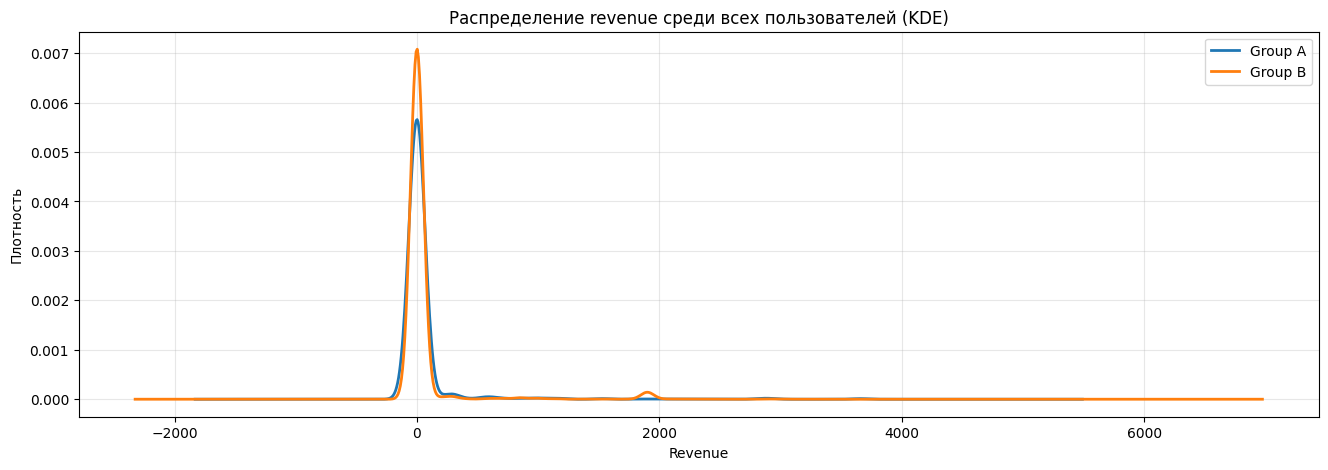

In [27]:
plt.figure(figsize=(16,5))

for g in users_full["group"].unique():
    subset = users_full[users_full["group"] == g]["revenue"]
    if len(subset) > 1:  # чтобы не падало, если мало данных
        subset.plot(kind="kde", label=f"Group {g}", lw=2)

plt.title("Распределение revenue среди всех пользователей (KDE)")
plt.xlabel("Revenue")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Проанализировав расперделение по графику, видим что оно скошено и имеет длинные хвосты для обеих групп. 
Но дисперсии по результатм теста Левена равны. В таком случае для тестирования используем t тест.

In [28]:
# T-тест при равных дисперсиях
group_a = users_full.loc[users_full['group'] == 'A', 'revenue']
group_b = users_full.loc[users_full['group'] == 'B', 'revenue']
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=True)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
    print("Различие статистически значимо (p < 0.05).")
else:
    print("Различие незначимо.")

T-statistic: -1.225
P-value: 0.220
Различие незначимо.


In [29]:
# Анализ ARPPU

# Проверим равенство дисперсий тестом Левена (для платящих)
group_a = users_full.loc[(users_full["group"] == "A") & (users_full["payer"]), "revenue"]
group_b = users_full.loc[(users_full["group"] == "B") & (users_full["payer"]), "revenue"]

stat_levene, p_levene = stats.levene(group_a, group_b)

print("Статистика Левена:", stat_levene)
print("p-value:", p_levene)

alpha = 0.05
if p_levene > alpha:
    print("Вывод: дисперсии равны")
else:
    print("Вывод: дисперсии отличаются")


Статистика Левена: 3.0756816999816055
p-value: 0.08025675761347022
Вывод: дисперсии равны


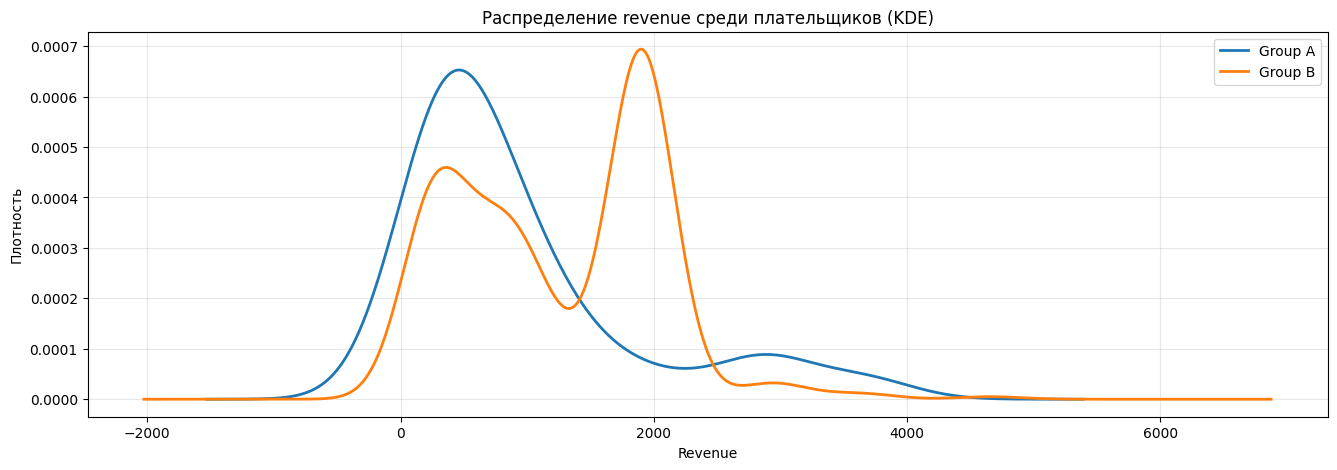

In [30]:
plt.figure(figsize=(16,5))

for g in users_full["group"].unique():
    subset = users_full[(users_full["group"] == g) & (users_full["revenue"] > 0)]["revenue"]
    if len(subset) > 1:  # чтобы не падало, если мало данных
        subset.plot(kind="kde", label=f"Group {g}", lw=2)

plt.title("Распределение revenue среди плательщиков (KDE)")
plt.xlabel("Revenue")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Проанализировав расперделение по графику, видим что оно имеет длинные хвосты в обеих группах, скошенно, ненормальное. 
Но дисперсии по результатм теста Левена равны. В таком случае для тестирования также возьмем t тест.

In [31]:
# T-тест при равных дисперсиях
group_a = users_full.loc[(users_full["group"] == "A") & (users_full["payer"]), "revenue"]
group_b = users_full.loc[(users_full["group"] == "B") & (users_full["payer"]), "revenue"]
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=True)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
    print("Различие статистически значимо (p < 0.05).")
else:
    print("Различие незначимо.")

T-statistic: -3.134
P-value: 0.002
Различие статистически значимо (p < 0.05).


### Выводы

1) Конверсия в группе A = 0.050715, в группе В = 0.046156. По результатам проведенных тестов, значения статистичеси не отличаются, мы не отклоняем нулевую гипотезу. Новая механика не увеличивает количество пользователей, коорые начинают платить, а даже немного снижает конверсию. 

2) ARPU (средний доход на пользователя) в группе A = 47.347204, в группе В = 58.058798. По результатам проведенных тестов,  различия статистически незначимы, хотя в тестовой группе наблюдается тенденция к росту.

3) ARPPU (средний доход на плательщика) в группе A = 933.589744, в группе В = 1257.878992. По результатам тестов - Различие статистически значимо (p < 0.05).В данном случае отклоняем нулевую гипотезу.


### Рекомендации

1) Если цель — увеличение выручки от платящих клиентов, то механику можно рассматривать как перспективную. Ее можно было бы запустить на всех пользователей, однако с учетом что она немного снижает конверсию - это может быть рискованно, хоть она и существенно увеличила ARPPU.

2) Если цель — увеличение числа платящих пользователей, то эффект не достигнут.

3) Стоит протестировать механику дополнительно (сегментировать пользователей, посмотреть, кто именно даёт рост ARPPU).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4be17dce-80ef-4cee-9f0e-a041cc84d2ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>